

In your project, you will pick a dataset (time-series) and an associated problem that can be solved via sequence models. You must describe why you need sequence models to solve this problem. Include a link to the dataset source. Next, you should pick an RNN framework that you would use to solve this problem (This framework can be in TensorFlow, PyTorch or any other Python Package).

For this problem, I will use the Ethereum-USD exchange rate data. This dataset contains the price of Etherum crypto-currency in a 1-minute interval. It contains information about market data relate to the currency, such as open, high, low and trade volume during the minute marker.

The dataset can be accessed in:

https://www.kaggle.com/datasets/patrickgendotti/btc-and-eth-1min-price-history


In [1]:
# same deal for gdrive and kaggle
from google.colab import drive
drive.mount('/content/drive')

!rm -r ~/.kaggle
!mkdir ~/.kaggle
!cp /content/drive/MyDrive/.kaggle/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!pip install -q kaggle


# download 

Mounted at /content/drive
rm: cannot remove '/root/.kaggle': No such file or directory


In [2]:
# install dataset and unzip

!rm -r dataset
!kaggle datasets download -d patrickgendotti/btc-and-eth-1min-price-history
!mkdir dataset
!unzip btc-and-eth-1min-price-history.zip -d dataset

rm: cannot remove 'dataset': No such file or directory
100% 118M/118M [00:00<00:00, 157MB/s] 
100% 118M/118M [00:00<00:00, 153MB/s]
Archive:  btc-and-eth-1min-price-history.zip
  inflating: dataset/ETH_1min.csv    
  inflating: dataset/coinbaseUSD_1-min_data.csv  


In [3]:
!pip install livelossplot -q

     |████████████████████████████████| 1.6 MB 6.7 MB/s 


In [4]:
import pandas as pd


raw_data = pd.read_csv('dataset/ETH_1min.csv')

raw_data.head()

Unix Timestamp                       Date   Symbol  Open  High   Low  \
0      1462800720  2016-05-09 13:32:00+00:00  ETH-USD   0.0  12.0   0.0   
1      1462800780  2016-05-09 13:33:00+00:00  ETH-USD  12.0  12.0  10.0   
2      1462800840  2016-05-09 13:34:00+00:00  ETH-USD  10.0  10.0  10.0   
3      1462800900  2016-05-09 13:35:00+00:00  ETH-USD  10.0  10.0  10.0   
4      1462800960  2016-05-09 13:36:00+00:00  ETH-USD  10.0  10.0  10.0   

   Close     Volume  
0   12.0   4.156276  
1   10.0  43.497506  
2   10.0   8.000000  
3   10.0  60.000000  
4   10.0   0.375000

In [5]:
# its probably sorted, but just to make sure
raw_data = raw_data.sort_values(by=['Unix Timestamp'])
# we don't need the date or symbol
# raw_data = raw_data.drop(['Date','Symbol','Unix Timestamp'],axis=1)

raw_data.describe()

Unix Timestamp          Open          High           Low         Close  \
count    3.054062e+06  3.054062e+06  3.054062e+06  3.054062e+06  3.054062e+06   
mean     1.557028e+09  8.450225e+02  8.456590e+02  8.443716e+02  8.450248e+02   
std      5.512279e+07  1.177972e+03  1.178885e+03  1.177041e+03  1.177974e+03   
min      1.462801e+09  0.000000e+00  5.990000e+00  0.000000e+00  5.990000e+00   
25%      1.508612e+09  1.446600e+02  1.447000e+02  1.446100e+02  1.446600e+02   
50%      1.556982e+09  2.790100e+02  2.791300e+02  2.789300e+02  2.790100e+02   
75%      1.605464e+09  8.549675e+02  8.551875e+02  8.545000e+02  8.549775e+02   
max      1.651281e+09  4.864970e+03  4.867810e+03  4.863000e+03  4.864970e+03   

             Volume  
count  3.054062e+06  
mean   7.264365e+01  
std    4.001419e+02  
min    0.000000e+00  
25%    0.000000e+00  
50%    6.771819e+00  
75%    6.753221e+01  
max    2.764235e+05

In [6]:
# the dataset is too huge to play around with on colab.. gonna convert it to 30 minute intervals 
INTERVAL = 30

raw_data = pd.DataFrame([
    {
        'Open':raw_data.Open.values[beg],
        'High':raw_data.High.values[beg:beg+INTERVAL].max(),
        'Low':raw_data.Low.values[beg:beg+INTERVAL].min(),
        'Close':raw_data.Close.values[beg+INTERVAL-1],
        'Volume':raw_data.Volume.values[beg:beg+INTERVAL].sum(),
    }
    for beg in range(0,len(raw_data)-INTERVAL,INTERVAL)
])

In [7]:
# just the price movement during the interval
raw_data['Delta'] = raw_data['High'] - raw_data['Low']
# this will be our target variable. The difference betwen current closing price and the next one
# price_change = raw_data.Close.values[1:] - raw_data.Close.values[:-1]
# raw_data = raw_data.iloc[:-1,:]
# raw_data['PriceChange'] = price_change

# target variable is "Close", which is the closing price. So we will move it to the back
raw_data = raw_data[[c for c in raw_data.columns if not c == 'Close'] + ['Close']]


# np.arange

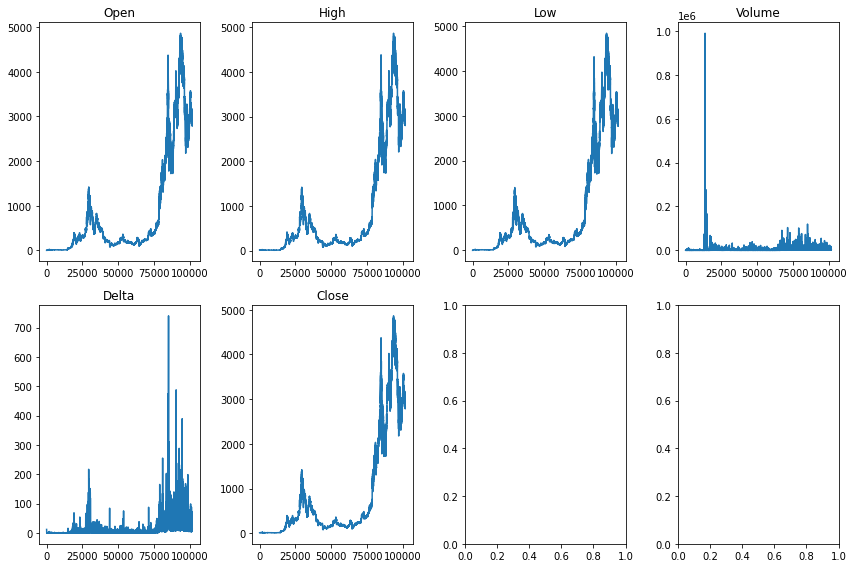

In [8]:
# examining feature distribution

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# numerical = X_raw.columns[X_raw.dtypes.isin([int,float])]
# numerical = dataset.select_dtypes(exclude=['object','bool'])
# X_raw.dtypes

fig,axes = plt.subplots(ncols=4,nrows=2,figsize=(12,8))

for c,ax in zip(raw_data.columns,axes.flatten()):
    raw_data[c].plot(ax=ax,title=c)
    # sns.lineplot(data=X_raw[c],ax=ax)


fig.tight_layout()

In [9]:
for c in raw_data.columns:
    print(f'Feature: {c} -- {raw_data[c].isna().sum()/raw_data.shape[0] * 100 :.4f}% values are NA')

Feature: Open -- 0.0000% values are NA
Feature: High -- 0.0000% values are NA
Feature: Low -- 0.0000% values are NA
Feature: Volume -- 0.0000% values are NA
Feature: Delta -- 0.0000% values are NA
Feature: Close -- 0.0000% values are NA


as expected, open/high/low follow the same pattern. Volume seems to die down as time goes. To check if the High/Low interval changes, I will add a new column

In [10]:
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# data_pt = torch.tensor(raw_data.values).float().cuda()

scaler = MinMaxScaler()
train_data,test_data = train_test_split(raw_data,test_size=0.1,shuffle=False)
train_data,dev_data = train_test_split(train_data,test_size= 0.1/0.9, shuffle=False)

train_data = torch.tensor(scaler.fit_transform(train_data)).float().cuda()
dev_data = torch.tensor(scaler.transform(dev_data)).float().cuda()
test_data = torch.tensor(scaler.transform(test_data)).float().cuda()

def build_sequence(data,bin_size=100):
    X = torch.stack([ data[i:i+bin_size,:] for i in range(data.size(0) - bin_size) ])
    y = data[bin_size:,-1]
    return X,y


# the dataset is huge, so we will load the original version to cuda first, so that we can simply slice out what we need
X_train,y_train = build_sequence(train_data)
X_dev,y_dev = build_sequence(dev_data)
X_test,y_test = build_sequence(test_data)

In [11]:
# To prepare the data for our models, need to create a dataset and loader

import torch
from torch.utils.data import DataLoader,Dataset

class ETHData(Dataset):
    def __init__(self,X,y):
        # self.data = data

        # X,y = [],[]
        self.X = X
        self.y = y
    def __len__(self,):
        return self.y.size(0)
    
    def __getitem__(self,idx):
        return (
            # notice that we are including past 'Close' column into the input data as well
            self.X[idx],
            self.y[idx]
        )

# train_data = ETHData(train_data)
# dev_data = ETHData(dev_data)
# test_data = ETHData(test_data)

## Task 1 (60 points):
### Part 1 (30 points): 
Implement your RNN either using an existing framework OR you can implement your own RNN cell structure. In either case, describe the structure of your RNN and the activation functions you are using for each time step and in the output layer. Define a metric you will use to measure the performance of your model 

NOTE: Performance should be measured both for the validation set and the test set.

I am using an implementation of RNN from pytorch to build my model. Since this problem is a regression task, I will use MSE loss to evaluate the model during training. For the optimizer, I am using Adam. And for the activation functions, I am using RELU between the RNN layers.

The structure of my RNN:
- hidden size: 20
- number of layers: 1

I tested with some different values for the number of layers and hidden size, and found that the models were already performing well enough with 1 layer while saving cuda memory. Same goes for hidden size, the mdoels performed very well with large hidden size, but I was not able to run all 3 implementations in one session with the setting so I compromised to 20.

In [12]:
torch.nn.GRU.__name__

'GRU'

In [13]:
from torch import nn,optim
from livelossplot import PlotLosses
from tqdm.auto import tqdm
from sklearn.metrics import r2_score,mean_squared_error

class RecurrentNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, layer_type='RNN'):
        super(RecurrentNet, self).__init__()
        
        # Number of hidden dimensions
        self.hidden_size = hidden_size
        
        # Number of hidden layers
        self.num_layers = num_layers
        
        # RNN https://pytorch.org/docs/stable/generated/torch.nn.RNN.html
        if layer_type=='RNN':
            self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True, nonlinearity='relu',dropout=1e-4)
        elif layer_type=='LSTM':
            self.rnn = nn.LSTM(input_size,hidden_size,num_layers,batch_first=True,dropout=1e-4)
        else:
            self.rnn = nn.GRU(input_size,hidden_size,num_layers,batch_first=True,dropout=1e-4)
        self.out_layer = nn.Linear(hidden_size, 1)


        # self.loss_func = nn.MSELoss()
    
    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).cuda()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).cuda()
            
        # One time step
        if self.rnn.__class__.__name__ in ['LSTM']:
            out, (hn,cn) = self.rnn(x, (h0, c0))
        else:
            out, hn = self.rnn(x, h0)
        out = self.out_layer(out[:, -1, :]) 
        return out[:,0]

    def train(
        self,
        X_train,
        y_train,
        X_dev,
        y_dev,
        num_epoch=100,
        lr=1e-4,
        wd=1e-3,
        loss_func=nn.MSELoss,
        extra_metrics=[r2_score,mean_squared_error]
    ):
        train_loader = DataLoader(ETHData(X_train,y_train),batch_size=512,shuffle=False)
        optimizer = optim.Adam(self.parameters(), lr=lr,weight_decay=wd)
        criterion = loss_func()

        liveloss = PlotLosses()
        for _ in range(num_epoch):
            all_losses = []
            y_real_train = []
            y_pred_train = []
            for x,y in tqdm(train_loader, desc='going through batches...',leave=False):
                optimizer.zero_grad()
                pred = self.forward(x)
                loss = criterion(pred,y)
                loss.backward()
                optimizer.step()

                all_losses.append(loss.item())
                y_real_train.append(y)
                y_pred_train.append(pred)
            
            all_real_train,all_pred_train = torch.hstack(y_real_train).detach().cpu(),torch.hstack(y_pred_train).detach().cpu()

            all_real_dev = y_dev.cpu()
            all_pred_dev = self.predict(X_dev).cpu()
            
            liveloss.update(dict(
                [
                    (loss_func.__name__, np.mean(all_losses))
                ] + [
                    (f'{m.__name__}_train',m(all_real_train,all_pred_train))
                    for m in extra_metrics
                ] + [
                    (f'{m.__name__}_dev',m(all_real_dev,all_pred_dev))
                    for m in extra_metrics
                ]
            ))
            liveloss.send()

    @torch.no_grad()
    def predict(self, X_input):
        return self.forward(X_input)
    
    @torch.no_grad()
    def score(self, X_input, y_input, metrics = [r2_score,mean_squared_error] ):
        pred = self.predict(X_input).cpu()
        return {
            m.__name__: m(y_input.cpu(),pred)
            for m in metrics
        }

In [14]:

def plot_predictions(model):
    fig,axes = plt.subplots(ncols=3,figsize=(20,4))

    pred_dev = model.predict(X_dev)
    pred_test = model.predict(X_test)

    # df = pd.DataFrame(torch.hstack([y_train,y_dev,y_test]).cpu(),columns=['Price Change'])
    # df['Type'] = ['Train'] * y_train.size(0) + ['Dev'] * y_dev.size(0) + ['Test'] * y_test.size(0)


    df_train_real = pd.DataFrame(y_train.cpu(),columns=['Price Change'])
    df_train_real['Type'] = 'Train'

    df_dev_real = pd.DataFrame(y_dev.cpu(),columns=['Price Change'])
    df_dev_real['Type'] = 'Dev'

    df_test_real = pd.DataFrame(y_test.cpu(),columns=['Price Change'])
    df_test_real['Type'] = 'Test'

    df_dev_pred = pd.DataFrame(pred_dev.cpu(),columns=['Price Change'])
    df_dev_pred['Type'] = 'Dev Prediction'

    df_test_pred = pd.DataFrame(pred_test.cpu(),columns=['Price Change'])
    df_test_pred['Type'] = 'Test Prediction'

    sns.lineplot(
        data=pd.concat([
            df_train_real,
            df_dev_real,
            df_test_real
        ]).reset_index(drop=True),
        y='Price Change',
        x = np.arange(len(y_train)+len(y_dev)+len(y_test)),
        hue='Type',
        ax=axes[0]
    )

    # compare with actual prediction
    # df[df.Type == 'Dev']
    df_dev = pd.concat([df_dev_real.reset_index(),df_dev_pred.reset_index()]).reset_index(drop=True)
    sns.lineplot(data=df_dev,x='index',y='Price Change',hue='Type',ax=axes[1])

    df_test = pd.concat([df_test_real.reset_index(),df_test_pred.reset_index()]).reset_index(drop=True)
    sns.lineplot(data=df_test,x='index',y='Price Change',hue='Type',ax=axes[2])

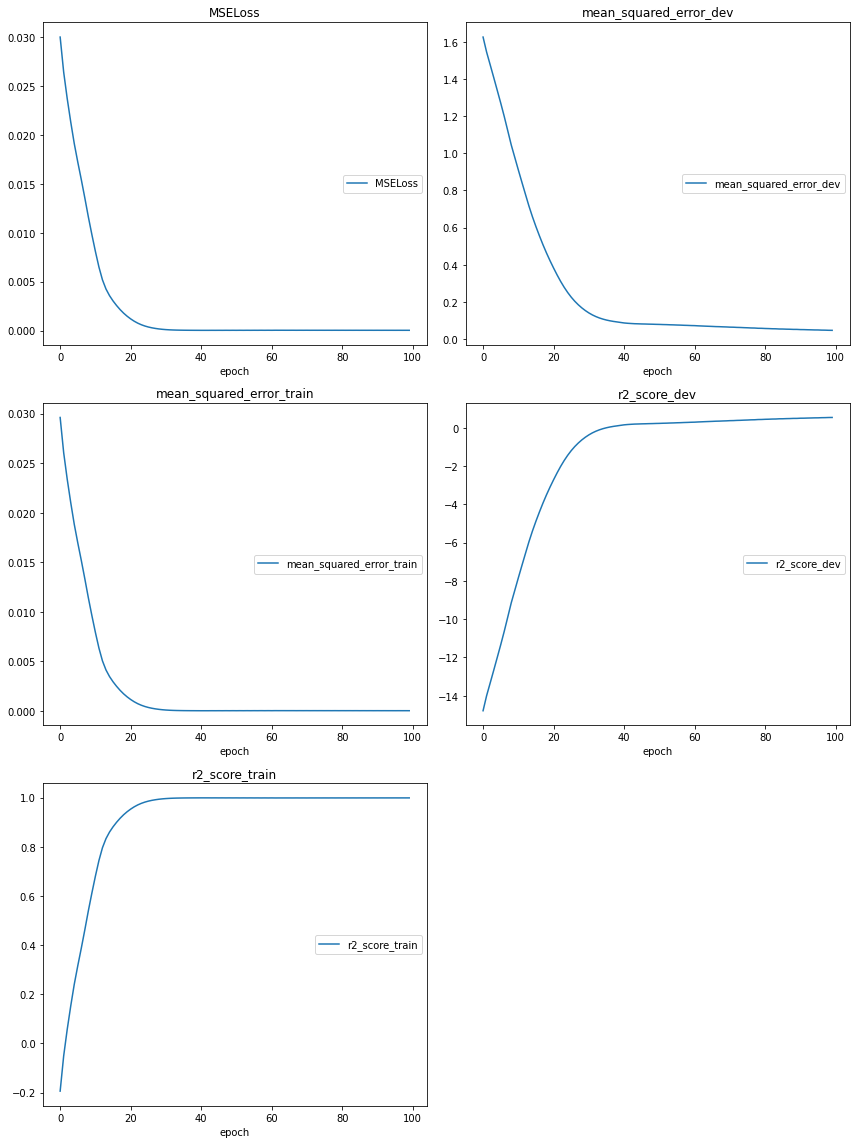

MSELoss
	MSELoss          	 (min:    0.000, max:    0.030, cur:    0.000)
mean_squared_error_dev
	mean_squared_error_dev 	 (min:    0.047, max:    1.625, cur:    0.047)
mean_squared_error_train
	mean_squared_error_train 	 (min:    0.000, max:    0.030, cur:    0.000)
r2_score_dev
	r2_score_dev     	 (min:  -14.783, max:    0.545, cur:    0.545)
r2_score_train
	r2_score_train   	 (min:   -0.194, max:    0.999, cur:    0.999)


In [15]:
rnn = RecurrentNet(raw_data.shape[1],20,1,layer_type='RNN').cuda()
rnn.train(X_train,y_train,X_dev,y_dev,num_epoch=100)

RNN Test Scores:
{'r2_score': -0.39623248189927107, 'mean_squared_error': 0.14465594}


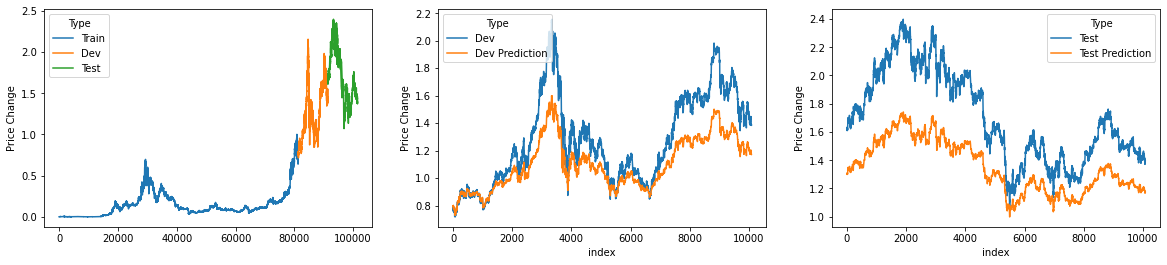

In [16]:
plot_predictions(rnn)

print('RNN Test Scores:')
print(rnn.score(X_test,y_test))

### Part 2 (35 points): 
Update your network from part 1 with first an LSTM and then a GRU based cell structure (You can treat both as 2 separate implementations). Re-do the training and performance evaluation. What are the major differences you notice? Why do you think those differences exist between the 3 implementations (basic RNN, LSTM and GRU)?

Note: In part 1 and 2, you must perform sufficient data-visualization, pre-processing and/or feature-engineering if needed. The overall performance visualization of the loss function should also be provided.


All 3 of the models (including RNN) performed pretty wel. Surprisingly, RNN performed the best, with GRU and then LSTM by the r2 score and MSE scores. 

The predicted sequence vs the ground truth can be seen after each model's training plots.

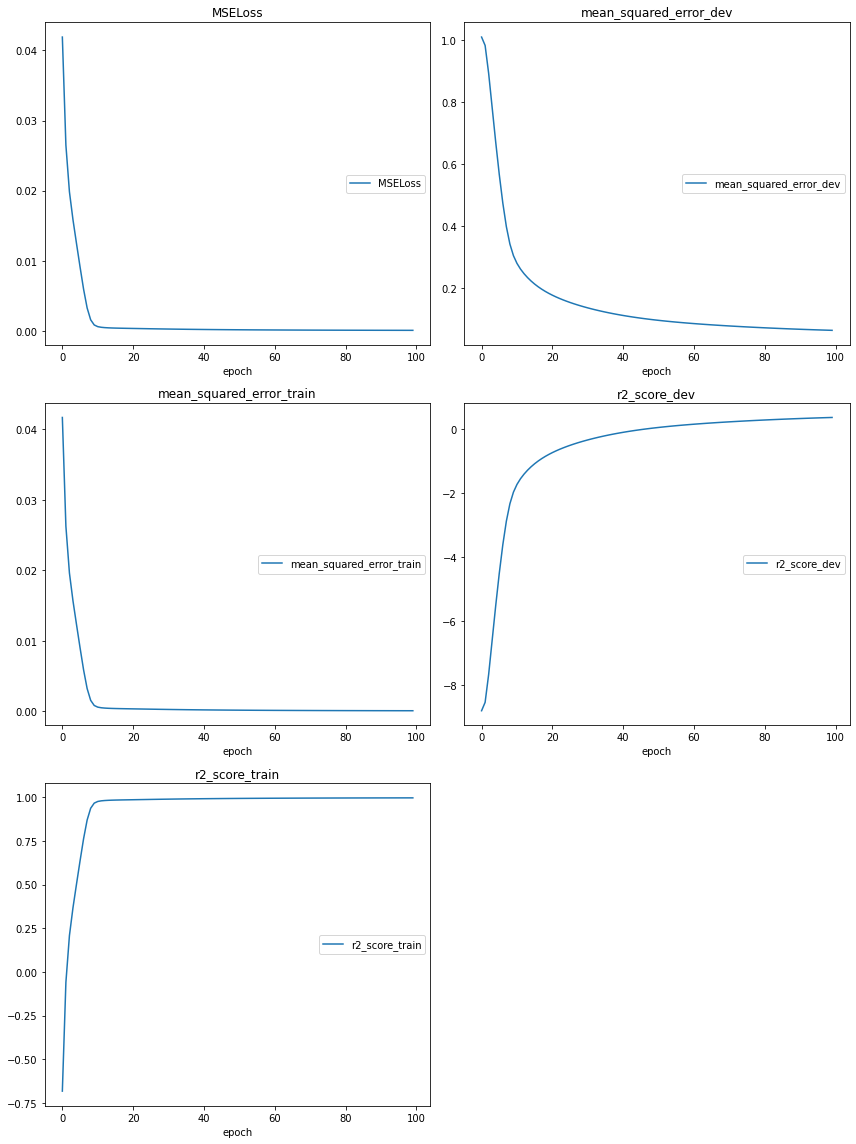

MSELoss
	MSELoss          	 (min:    0.000, max:    0.042, cur:    0.000)
mean_squared_error_dev
	mean_squared_error_dev 	 (min:    0.064, max:    1.009, cur:    0.064)
mean_squared_error_train
	mean_squared_error_train 	 (min:    0.000, max:    0.042, cur:    0.000)
r2_score_dev
	r2_score_dev     	 (min:   -8.795, max:    0.374, cur:    0.374)
r2_score_train
	r2_score_train   	 (min:   -0.682, max:    0.997, cur:    0.997)


In [17]:
lstm = RecurrentNet(raw_data.shape[1],20,1,layer_type='LSTM').cuda()
lstm.train(X_train,y_train,X_dev,y_dev,num_epoch=100)

LSTM Test Scores:
{'r2_score': -1.1666671880429855, 'mean_squared_error': 0.22447641}


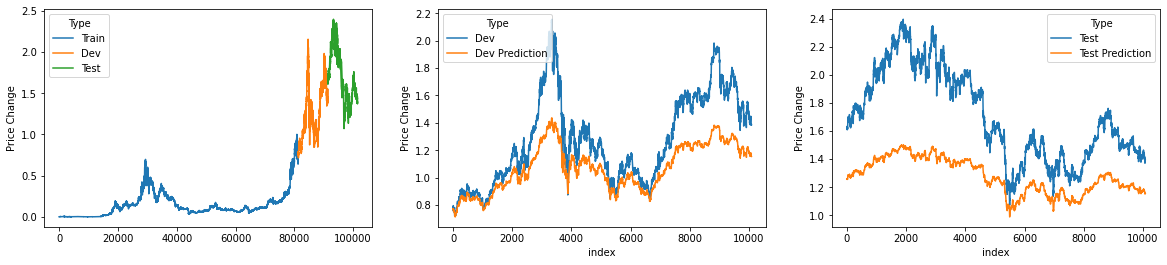

In [18]:
plot_predictions(lstm)
print('LSTM Test Scores:')
print(lstm.score(X_test,y_test))

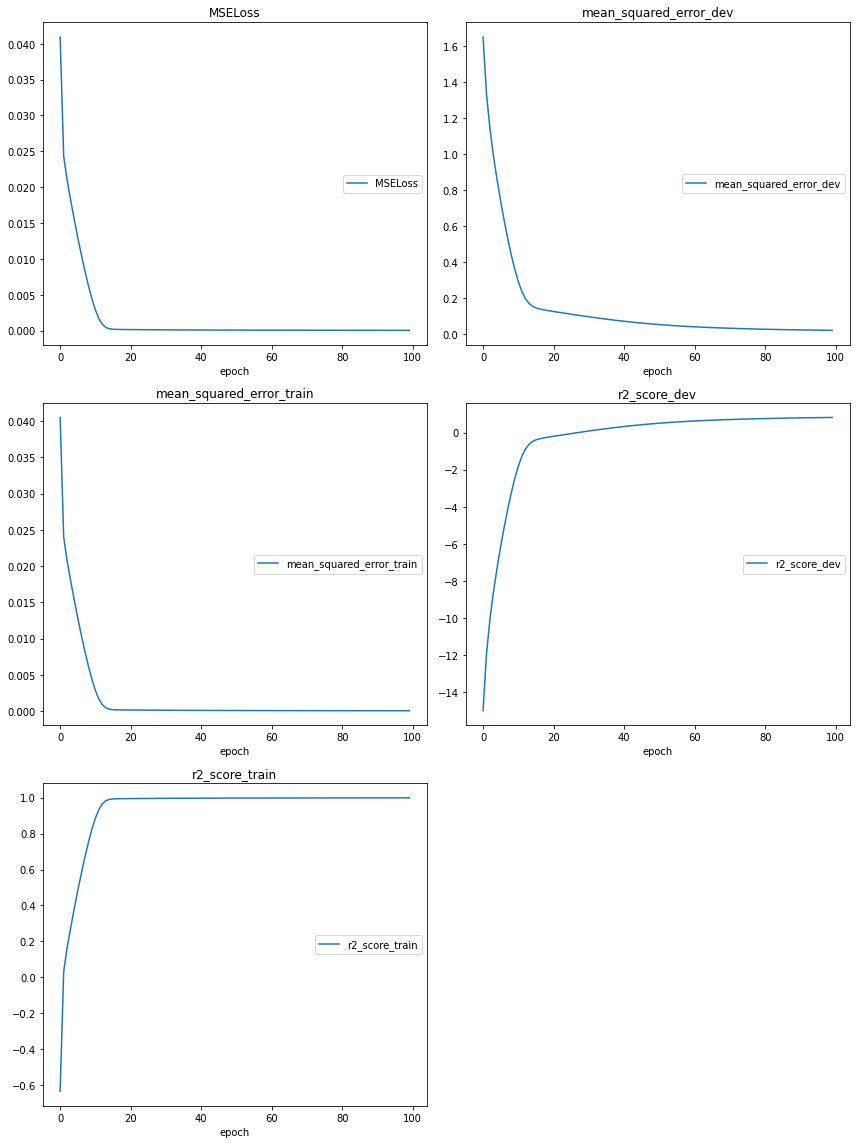

MSELoss
	MSELoss          	 (min:    0.000, max:    0.041, cur:    0.000)
mean_squared_error_dev
	mean_squared_error_dev 	 (min:    0.019, max:    1.648, cur:    0.019)
mean_squared_error_train
	mean_squared_error_train 	 (min:    0.000, max:    0.041, cur:    0.000)
r2_score_dev
	r2_score_dev     	 (min:  -15.005, max:    0.818, cur:    0.818)
r2_score_train
	r2_score_train   	 (min:   -0.634, max:    0.999, cur:    0.999)


In [19]:
gru = RecurrentNet(raw_data.shape[1],20,1,layer_type='GRU').cuda()
gru.train(X_train,y_train,X_dev,y_dev,num_epoch=100)

GRU Test Scores:
{'r2_score': 0.28732910543956114, 'mean_squared_error': 0.07383589}


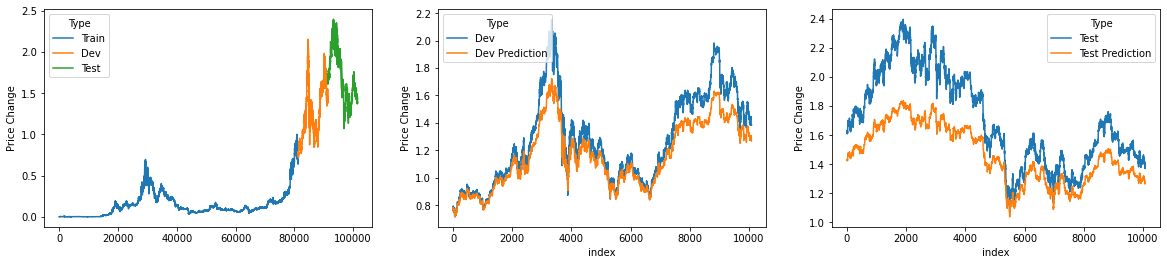

In [20]:
plot_predictions(gru)

print('GRU Test Scores:')
print(gru.score(X_test,y_test))


### Part 3 (10 points): 
Can you use the traditional feed-forward network to solve the same problem. Why or why not? 

Hint: Can time series data be converted to usual features that can be used as input to a feed-forward network?

No, traditional feed-forward networks (MLPs) cannot be used to solve the same problem as RNNs do. MLPs require the data to be representable per row, which means that time series data cannot be converted into the proper input. 




## Task 2 (25 points): 
In this task, use any of the pre-trained word embeddings. The Wor2vec embedding link provided with the lecture notes can be useful to get started. Write your own code/function that uses these embeddings and outputs cosine similarity and a dissimilarity score for any 2 pair of words (read as user input). The dissimilarity score should be defined by you. You either can have your own idea of a dissimilarity score or refer to literature (cite the paper you used). In 
either case clearly describe how this score helps determine the dissimilarity between 2 words.

Note: Dissimilarity measure has been an important metric for recommender systems trying to introduce ‘Novelty and Diversity’ in assortments (as opposed to only accuracy). You might find different metrics of dissimilarity in recommender system’s literature